In [1]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/nird/home/ovewh/dustysnake/lib/python3.10/site-packages', '/nird/home/ovewh/.cache/snakemake/snakemake/source-cache/runtime-cache/tmpm3dzv1ix/file/nird/home/ovewh/Climaso/workflow/rules/../notebooks/dust_analysis', '/nird/home/ovewh/Climaso/workflow/rules/../notebooks/dust_analysis']); import pickle; snakemake = pickle.loads(b'\x80\x04\x95\xc6\x1d\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8cl/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_NorESM2-LM_piClim-control.nc\x94\x8cq/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_MPI-ESM-1-2-HAM_piClim-control.nc\x94\x8cs/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_EC-Earth3-AerChem_piClim-control.nc\x94\x8cm/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_GISS-E2-1-G_piClim-control.nc\x94\x8cm/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_UKESM1-0-LL_piClim-control.nc\x94\x8ch/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_MIROC6_piClim-control.nc\x94\x8cs/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_IPSL-CM6A-LR-INCA_piClim-control.nc\x94\x8ck/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_GFDL-ESM4_piClim-control.nc\x94\x8cm/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_CNRM-ESM2-1_piClim-control.nc\x94\x8ck/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_NorESM2-LM_piClim-2xdust.nc\x94\x8cp/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_MPI-ESM-1-2-HAM_piClim-2xdust.nc\x94\x8cr/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_EC-Earth3-AerChem_piClim-2xdust.nc\x94\x8cl/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_GISS-E2-1-G_piClim-2xdust.nc\x94\x8cl/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_UKESM1-0-LL_piClim-2xdust.nc\x94\x8cg/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_MIROC6_piClim-2xdust.nc\x94\x8cr/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_IPSL-CM6A-LR-INCA_piClim-2xdust.nc\x94\x8cj/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_GFDL-ESM4_piClim-2xdust.nc\x94\x8cl/projects/NS2345K/ovewh/DustForcingData/results/dust_diag_files/dust_cloud_diag_CNRM-ESM2-1_piClim-2xdust.nc\x94\x8cE/projects/NS2345K/ovewh/DustForcingData/results/masks/dust_regions.nc\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\tctrl_data\x94K\x00K\t\x86\x94\x8c\x08exp_data\x94K\tK\x12\x86\x94\x8c\x04mask\x94K\x12N\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eh(\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(h.)}\x94\x8c\x05_name\x94h(sNt\x94bh)h,h.\x85\x94R\x94(h.)}\x94h2h)sNt\x94bh h\x06\x8c\tNamedlist\x94\x93\x94)\x81\x94(h\nh\x0bh\x0ch\rh\x0eh\x0fh\x10h\x11h\x12e}\x94(h\x1e}\x94h&]\x94(h(h)eh(h,h.\x85\x94R\x94(h.)}\x94h2h(sNt\x94bh)h,h.\x85\x94R\x94(h.)}\x94h2h)sNt\x94bubh"h9)\x81\x94(h\x13h\x14h\x15h\x16h\x17h\x18h\x19h\x1ah\x1be}\x94(h\x1e}\x94h&]\x94(h(h)eh(h,h.\x85\x94R\x94(h.)}\x94h2h(sNt\x94bh)h,h.\x85\x94R\x94(h.)}\x94h2h)sNt\x94bubh$h\x1cub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94\x8c_/projects/NS2345K/ovewh/DustForcingData/results/figs/AerChemMIP/dust_cloud_diagnostic_table.pdf\x94a}\x94(h\x1e}\x94\x8c\x07outpath\x94K\x00N\x86\x94sh&]\x94(h(h)eh(h,h.\x85\x94R\x94(h.)}\x94h2h(sNt\x94bh)h,h.\x85\x94R\x94(h.)}\x94h2h)sNt\x94bhYhVub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94}\x94(h\x1e}\x94h&]\x94(h(h)eh(h,h.\x85\x94R\x94(h.)}\x94h2h(sNt\x94bh)h,h.\x85\x94R\x94(h.)}\x94h2h)sNt\x94bub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94}\x94(h\x1e}\x94h&]\x94(h(h)eh(h,h.\x85\x94R\x94(h.)}\x94h2h(sNt\x94bh)h,h.\x85\x94R\x94(h.)}\x94h2h)sNt\x94bub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01\x8c\x04/tmp\x94e}\x94(h\x1e}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94\x8c\x06tmpdir\x94K\x02N\x86\x94uh&]\x94(h(h)eh(h,h.\x85\x94R\x94(h.)}\x94h2h(sNt\x94bh)h,h.\x85\x94R\x94(h.)}\x94h2h)sNt\x94bh\x8aK\x01h\x8cK\x01h\x8eh\x87ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94}\x94(h\x1e}\x94h&]\x94(h(h)eh(h,h.\x85\x94R\x94(h.)}\x94h2h(sNt\x94bh)h,h.\x85\x94R\x94(h.)}\x94h2h)sNt\x94bub\x8c\x06config\x94}\x94(\x8c\troot_nird\x94\x8c!/nird/datalake/NS9560K/ESGF/CMIP6\x94\x8c\x0broot_lustre\x94\x8c+/lustre/storeB/users/oveh/.synda/data/CMIP6\x94\x8c\x0broot_noresm\x94\x8c\x17/projects/NS9034K/CMIP6\x94\x8c\x0eroot_noresmdev\x94\x8c>/home/oveh/mnt/NIRD_data/NorESM2_AerChemMIP_rerun_bugfix/CMIP6\x94\x8c\x06lustre\x94\x89\x8c\x07sources\x94]\x94(\x8c\x04nird\x94\x8c\x06noresm\x94e\x8c\x0fseperate_Noresm\x94\x88\x8c\x0ccmip_version\x94\x8c\x05CMIP6\x94\x8c\nactivities\x94]\x94(\x8c\nAerChemMIP\x94\x8c\x05RFMIP\x94e\x8c\rregrid_params\x94}\x94\x8c\x04dxdy\x94]\x94(G?\xfc\x00\x00\x00\x00\x00\x00G@\x00\x00\x00\x00\x00\x00\x00es\x8c\routput_format\x94\x8c\x07default\x94\x8c\x07out_dir\x94\x8c0/projects/NS2345K/ovewh/DustForcingData/results/\x94\x8c\x15no_intermediate_files\x94\x89\x8c\ntime_slice\x94}\x94(\x8c\x05start\x94K\x02\x8c\x03end\x94Nu\x8c\x0fvariant_default\x94\x8c\x08r1i1p1f1\x94\x8c\x16model_specific_variant\x94}\x94(\x8c\x0epiClim-control\x94}\x94(\x8c\x0bUKESM1-0-LL\x94\x8c\x08r1i1p1f4\x94\x8c\x0bGISS-E2-1-G\x94\x8c\x08r1i1p3f1\x94\x8c\x0bCNRM-ESM2-1\x94\x8c\x08r1i1p1f2\x94\x8c\x06MIROC6\x94\x8c\tr11i1p1f1\x94\x8c\nNorESM2-LM\x94\x8c\x08r1i1p2f1\x94\x8c\x11NorESM2.0.6dev-LM\x94\x8c\x08r1i1p3f1\x94u\x8c\rpiClim-2xdust\x94}\x94(\x8c\x0bUKESM1-0-LL\x94\x8c\x08r1i1p1f4\x94\x8c\x0bGISS-E2-1-G\x94\x8c\x08r1i1p3f1\x94\x8c\x0bCNRM-ESM2-1\x94\x8c\x08r1i1p1f2\x94\x8c\nNorESM2-LM\x94\x8c\x08r1i1p2f1\x94\x8c\x11NorESM2.0.6dev-LM\x94\x8c\x08r1i1p3f1\x94uu\x8c\x0bexperiments\x94}\x94(\x8c\x07control\x94]\x94\x8c\x0epiClim-control\x94a\x8c\x0bexperiments\x94]\x94(\x8c\rpiClim-2xdust\x94\x8c\x0cabrupt-4xCO2\x94\x8c\tpiControl\x94\x8c\npiClim-aer\x94\x8c\x07histSST\x94\x8c\nhist-piAer\x94\x8c\rhistSST-piAer\x94\x8c\nhistorical\x94\x8c\thist-noLu\x94\x8c\x0bpiClim-2xss\x94\x8c\x0cpiClim-2xDMS\x94\x8c\tpiClim-lu\x94\x8c\npiClim-CH4\x94\x8c\x0bpiClim-NTCF\x94\x8c\tpiClim-BC\x94\x8c\npiClim-SO2\x94\x8c\tpiClim-OC\x94eu\x8c\x10table_id_default\x94\x8c\x04Amon\x94\x8c\x10use_derived_vars\x94}\x94(\x8c\x08loaddust\x94}\x94\x8c\x03all\x94\x88s\x8c\x06rlutaf\x94}\x94(\x8c\x11IPSL-CM6A-LR-INCA\x94\x88\x8c\x03all\x94\x89uu\x8c\ttable_ids\x94}\x94(\x8c\x06rlutaf\x94\x8c\x06AERmon\x94\x8c\x08rsutcsaf\x94\x8c\x06AERmon\x94\x8c\x06rsutaf\x94\x8c\x06AERmon\x94\x8c\x08rlutcsaf\x94\x8c\x06AERmon\x94\x8c\x07emidust\x94\x8c\x06AERmon\x94\x8c\tod550dust\x94\x8c\x06AERmon\x94\x8c\x08od550aer\x94\x8c\x06AERmon\x94\x8c\nod550csaer\x94\x8c\x06AERmon\x94\x8c\x0bod550lt1aer\x94\x8c\x06AERmon\x94\x8c\x03lwp\x94\x8c\x06AERmon\x94\x8c\x04cdnc\x94\x8c\x06AERmon\x94\x8c\x07mmrdust\x94\x8c\x06AERmon\x94\x8c\x07od550bb\x94\x8c\x06AERmon\x94\x8c\x07airmass\x94\x8c\x06AERmon\x94\x8c\x05mmrss\x94\x8c\x06AERmon\x94\x8c\x06mmrsoa\x94\x8c\x06AERmon\x94\x8c\x05mmroa\x94\x8c\x06AERmon\x94\x8c\x05mmrbc\x94\x8c\x06AERmon\x94\x8c\x06mmrso4\x94\x8c\x06AERmon\x94\x8c\x08loaddust\x94\x8c\x06AERmon\x94\x8c\x08concdust\x94\x8c\x06AERmon\x94\x8c\x03ccn\x94\x8c\x06AERmon\x94\x8c\tabs550aer\x94\x8c\x06AERmon\x94u\x8c\tvariables\x94}\x94(\x8c\x04ERFt\x94]\x94(\x8c\x04rsut\x94\x8c\x04rsdt\x94\x8c\x04rlut\x94e\x8c\x06ERFtcs\x94]\x94(\x8c\x06rsutcs\x94\x8c\x04rsdt\x94\x8c\x06rlutcs\x94e\x8c\x06ERFtaf\x94]\x94(\x8c\x06rsutaf\x94\x8c\x04rsdt\x94\x8c\x06rlutaf\x94e\x8c\x08ERFtcsaf\x94]\x94(\x8c\x08rsutcsaf\x94\x8c\x04rsdt\x94\x8c\x08rlutcsaf\x94e\x8c\x06ERFtsw\x94]\x94(\x8c\x04rsut\x94\x8c\x04rsdt\x94e\x8c\x08ERFtswaf\x94]\x94(\x8c\x06rsutaf\x94\x8c\x04rsdt\x94e\x8c\nERFtswcsaf\x94]\x94(\x8c\x08rsutcsaf\x94\x8c\x04rsdt\x94e\x8c\x06ERFtlw\x94]\x94\x8c\x04rlut\x94a\x8c\x08ERFtlwaf\x94]\x94\x8c\x06rlutaf\x94a\x8c\x08ERFtlwcs\x94]\x94\x8c\x06rlutcs\x94a\x8c\nERFtlwcsaf\x94]\x94\x8c\x08rlutcsaf\x94a\x8c\tERFsurfsw\x94]\x94(\x8c\x04rsus\x94\x8c\x04rsds\x94e\x8c\tERFsurflw\x94]\x94(\x8c\x04rlus\x94\x8c\x04rlds\x94e\x8c\x0bERFsurfswcs\x94]\x94(\x8c\x06rsuscs\x94\x8c\x06rsdscs\x94e\x8c\x08ERFtswcs\x94]\x94(\x8c\x06rsutcs\x94\x8c\x04rsdt\x94e\x8c\x07ERFsurf\x94]\x94(\x8c\x04rsus\x94\x8c\x04rsds\x94\x8c\x04rlus\x94\x8c\x04rlds\x94e\x8c\tERFsurfcs\x94]\x94(\x8c\x06rsuscs\x94\x8c\x06rsdscs\x94\x8c\x06rsutcs\x94\x8c\x04rlus\x94e\x8c\tDirectEff\x94]\x94(\x8c\x04ERFt\x94\x8c\x06ERFtaf\x94e\x8c\x0bSWDirectEff\x94]\x94(\x8c\x06ERFtsw\x94\x8c\x08ERFtswaf\x94e\x8c\x0eSWDirectEff_cs\x94]\x94(\x8c\x08ERFtswcs\x94\x8c\nERFtswcsaf\x94e\x8c\x0bLWDirectEff\x94]\x94(\x8c\x06ERFtlw\x94\x8c\x08ERFtlwaf\x94e\x8c\x0eLWDirectEff_cs\x94]\x94(\x8c\x08ERFtlwcs\x94\x8c\nERFtlwcsaf\x94e\x8c\x08CloudEff\x94]\x94(\x8c\x06ERFtaf\x94\x8c\x08ERFtcsaf\x94e\x8c\nSWCloudEff\x94]\x94(\x8c\x08ERFtswaf\x94\x8c\nERFtswcsaf\x94e\x8c\nLWCloudEff\x94]\x94(\x8c\x08ERFtlwaf\x94\x8c\nERFtlwcsaf\x94e\x8c\x08atmabsSW\x94]\x94(\x8c\x06ERFtsw\x94\x8c\tERFsurfsw\x94e\x8c\x06atmabs\x94]\x94(\x8c\x04ERFt\x94\x8c\x07ERFsurf\x94e\x8c\x08atmabsLW\x94]\x94(\x8c\x06ERFtlw\x94\x8c\tERFsurflw\x94eu\x8c\x0cburdens_dict\x94}\x94(\x8c\x08concdust\x94\x8c\x07mmrdust\x94\x8c\x07concpm1\x94\x8c\x06mmrpm1\x94\x8c\x08concpm10\x94\x8c\x07mmrpm10\x94\x8c\tconcpm2p5\x94\x8c\x08mmrpm2p5\x94\x8c\x07concso4\x94\x8c\x06mmrso4\x94\x8c\x06concss\x94\x8c\x05mmrss\x94\x8c\x07concsoa\x94\x8c\x06mmrsoa\x94\x8c\x06concoa\x94\x8c\x05mmroa\x94\x8c\nconch2oaer\x94\x8c\tmmraerh2o\x94u\x8c\x11accumalative_vars\x94]\x94(\x8c\x07emidust\x94\x8c\x07depdust\x94\x8c\x08concdust\x94\x8c\x08loaddust\x94e\x8c\tcloud_def\x94}\x94(\x8c\x03low\x94}\x94(\x8c\x06bottom\x94M\xe8\x03\x8c\x03top\x94M\xbc\x02u\x8c\x06middle\x94}\x94(\x8c\x06bottom\x94M\xbc\x02\x8c\x03top\x94M\x90\x01u\x8c\x04high\x94}\x94(\x8c\x06bottom\x94M\x90\x01\x8c\x03top\x94K2uu\x8c\x10cloud_def_height\x94}\x94(\x8c\x03low\x94}\x94(\x8c\x06bottom\x94K\x00\x8c\x03top\x94M\xb8\x0bu\x8c\x06middle\x94}\x94(\x8c\x06bottom\x94M\xb8\x0b\x8c\x03top\x94Mp\x17u\x8c\x04high\x94}\x94(\x8c\x06bottom\x94Mp\x17\x8c\x03top\x94Nuu\x8c\x11variable_scalings\x94}\x94(\x8c\x05clivi\x94}\x94(\x8c\x01c\x94M\xe8\x03\x8c\x05units\x94\x8c\x05g m-2\x94u\x8c\x05clwvi\x94}\x94(j\xec\x01\x00\x00M\xe8\x03\x8c\x05units\x94\x8c\x05g m-2\x94u\x8c\x03cli\x94}\x94(j\xec\x01\x00\x00M\xe8\x03\x8c\x05units\x94\x8c\x05g g-1\x94u\x8c\x04cdnc\x94}\x94(j\xec\x01\x00\x00G>z\xd7\xf2\x9a\xbc\xafH\x8c\x05units\x94\x8c\x06# cm-3\x94u\x8c\x07mmrdust\x94}\x94(j\xec\x01\x00\x00M\xe8\x03\x8c\x05units\x94\x8c\x05g g-1\x94uu\x8c\x13dust_source_regions\x94}\x94(\x8c\x14Western north Africa\x94}\x94(\x8c\x06latmin\x94K\x12\x8c\x06latmax\x94G@B\xc0\x00\x00\x00\x00\x00\x8c\x06lonmin\x94J\xec\xff\xff\xff\x8c\x06lonmax\x94G@\x1e\x00\x00\x00\x00\x00\x00u\x8c\x14Eastern north Africa\x94}\x94(\x8c\x06latmin\x94K\x12\x8c\x06latmax\x94G@B\xc0\x00\x00\x00\x00\x00\x8c\x06lonmin\x94G@\x1e\x00\x00\x00\x00\x00\x00\x8c\x06lonmax\x94K#u\x8c\x05Sahel\x94}\x94(\x8c\x06latmin\x94K\x00\x8c\x06latmax\x94K\x12\x8c\x06lonmin\x94J\xec\xff\xff\xff\x8c\x06lonmax\x94K#u\x8c\x0bMiddle east\x94}\x94(\x8c\x06latmin\x94K\x00\x8c\x06latmax\x94K#\x8c\x06lonmin\x94K#\x8c\x06lonmax\x94KKu\x8c\x0cCentral Asia\x94}\x94(\x8c\x06latmin\x94K#\x8c\x06latmax\x94K2\x8c\x06lonmin\x94K#\x8c\x06lonmax\x94KFu\x8c\x0fSouthern Africa\x94}\x94(\x8c\x06latmin\x94J\xd8\xff\xff\xff\x8c\x06latmax\x94K\x00\x8c\x06lonmin\x94K\x00\x8c\x06lonmax\x94K(u\x8c\tEast Asia\x94}\x94(\x8c\x06latmin\x94K#\x8c\x06latmax\x94K2\x8c\x06lonmin\x94KF\x8c\x06lonmax\x94Kxu\x8c\rNorth America\x94}\x94(\x8c\x06latmin\x94K\x14\x8c\x06latmax\x94K-\x8c\x06lonmin\x94J~\xff\xff\xff\x8c\x06lonmax\x94J\xb0\xff\xff\xffu\x8c\tAustralia\x94}\x94(\x8c\x06latmin\x94J\xd8\xff\xff\xff\x8c\x06latmax\x94J\xf6\xff\xff\xff\x8c\x06lonmin\x94Kn\x8c\x06lonmax\x94K\xa0u\x8c\rSouth America\x94}\x94(\x8c\x06latmin\x94J\xc4\xff\xff\xff\x8c\x06latmax\x94K\x00\x8c\x06lonmin\x94J\xb0\xff\xff\xff\x8c\x06lonmax\x94J\xec\xff\xff\xffuuu\x8c\x04rule\x94\x8c\x1bplot_cloud_diagnostic_table\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8cB/nird/home/ovewh/Climaso/workflow/rules/../notebooks/dust_analysis\x94ub.'); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir(r'/nird/home/ovewh/Climaso');
######## snakemake preamble end #########


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from workflow.scripts.utils import global_avg
import matplotlib as mpl
import pandas as pd
import numpy as np


In [3]:
ds_exp = {p.split("_")[-2]: xr.open_dataset(p) for p in snakemake.input.exp_data}
ds_ctrl = {p.split("_")[-2]: xr.open_dataset(p) for p in snakemake.input.ctrl_data}

In [8]:
def _fill_diag_df(data,df, variables):
    
    for variable in variables:
        temp_data = data.get(variable)
        if temp_data is None:
            df[variable] = np.nan
        else:
            df[variable] = temp_data.values
    return df


def create_diagnostics_df(ds_ctrl, ds_exp, mod_id,
                        variables=['lwp','pr','cl_low','cl_middle','cl_high','cdncvi','clt','clivi']
                        ):
    ctrl = ds_ctrl.mean(dim='time')
    exp = ds_exp.mean(dim='time')

    if np.all(ctrl.lat.values == exp.lat.values):
        diff = exp - ctrl
    else:
        exp = exp.assign_coords(lat=ctrl.lat.values)
        diff = exp - ctrl
    ctrl = global_avg(ctrl)
    exp = global_avg(exp)
    diff = global_avg(diff)


    series_exp = pd.Series(index=variables,name=mod_id)
    series_ctrl = pd.Series(index=variables,name=mod_id)
    series_diff = pd.Series(index=variables,name=mod_id)
    reldiff = pd.Series(index=variables,name=mod_id)

    series_exp = _fill_diag_df(exp,series_exp,variables)
    series_ctrl = _fill_diag_df(ctrl,series_ctrl,variables)
    series_diff = _fill_diag_df(diff,series_diff,variables)


    for variable in variables:

        if ctrl.get(variable) is not None:
            reldiff[variable] = diff[variable].values/ctrl[variable].values*100

    return series_exp,series_ctrl, reldiff, series_diff


In [9]:
dfs = []
rel_dfs = []
dfs_ctrl =  []
dfs_diff = []
for mod_id in ds_exp:
    exp,ctrl,temp_rel,diff = create_diagnostics_df(ds_ctrl[mod_id], ds_exp[mod_id], mod_id)
    dfs.append(exp)
    rel_dfs.append(temp_rel)
    dfs_ctrl.append(ctrl)
    dfs_diff.append(diff)

In [10]:
df = pd.DataFrame(dfs).sort_index()
df_rel = pd.DataFrame(rel_dfs).sort_index()
df_ctrl = pd.DataFrame(dfs_ctrl).sort_index()
df_diff = pd.DataFrame(dfs_diff).sort_index()

In [76]:
def _get_fmt(data):
    if abs(data) > 100:
        valfmt_temp = mpl.ticker.StrMethodFormatter("{x:.0f}")
    elif abs(data) > 1:
        valfmt_temp = mpl.ticker.StrMethodFormatter("{x:.1f}")
    elif abs(data) < 0.3:
        valfmt_temp = mpl.ticker.StrMethodFormatter("{x:.3f}")
    else:
        valfmt_temp = mpl.ticker.StrMethodFormatter("{x:.2f}")
            # print(data[i,j],data[i,j] is np.nan)
    return valfmt_temp(data)
def annotate_heatmap(im,data, rel_change=None,valfmt="{x:.2f}", 
                     textcolors=["black", "white"], threshold=3, **textkw):
    """
    A function to annotate a heatmap.
    """
    # Normalize the threshold to the images color range.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",verticalalignment="center")
    kw.update(textkw)
    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)
    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    cdata = im.get_array().data



    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(abs(cdata[i, j]) > threshold)])
            if data[i,j] > 100:
                valfmt_temp = mpl.ticker.StrMethodFormatter("{x:.0f}")
            elif data[i,j] > 1:
                valfmt_temp = mpl.ticker.StrMethodFormatter("{x:.1f}")
            elif data[i,j] < 0.3:
                valfmt_temp = mpl.ticker.StrMethodFormatter("{x:.3f}")
            else:
                valfmt_temp = mpl.ticker.StrMethodFormatter("{x:.2f}")
            # print(data[i,j],data[i,j] is np.nan)
            if np.isnan(data[i,j]):
                texts.append('')
            else:
                if rel_change is not None:
                    text = im.axes.text(j, i, f"{_get_fmt(data[i, j])}\n ({_get_fmt(rel_change[i, j])} %)", **kw)
                else:
                    text = im.axes.text(j, i, f"{_get_fmt(data[i, j])}", **kw)
            texts.append(text)

    return texts

In [42]:
translate_column_names = {
    'lwp': {'name':'LWP \n (g m$^{-2}$)',
            'scale':1e3},
    'pr': {'name':'Precip \n (mm year$^{-1}$)',
            'scale': 1},
    'cl_low': {'name':'$\mathrm{CldFrac}_{low}$ \n [%]',
            'scale': 1},
    'cl_middle': {'name':'$\mathrm{CldFrac}_{mid}$ \n (%)',
            'scale': 1},
    'cl_high': {'name':'$\mathrm{CldFrac}_{high}$ \n (%)', 
            'scale': 1},
    'cdncvi': {'name':'$\mathrm{N_d}$ \n (cm$^{-3}$)',
            'scale': 1e-6},
    'clt': {'name':'CldFrac \n (-)',
            'scale': 1},
    'clivi': {'name':'IWP \n (g m$^{-2}$)',
            'scale': 1e3},

}

In [51]:
df_rel

,lwp,pr,cl_low,cl_middle,cl_high,cdncvi,clt,clivi
CNRM-ESM2-1,0.112449,-0.028388,0.205284,-0.083692,0.047886,-0.025557,0.083209,-0.025179
EC-Earth3-AerChem,-2.524329,0.027642,-0.601307,-0.361267,0.071785,-1.633353,-0.168942,-0.050238
GFDL-ESM4,-0.041091,-0.273560,0.184308,-0.348293,-0.208388,-0.036518,-0.172600,0.015318
GISS-E2-1-G,-0.071808,-0.298946,0.295418,-0.110185,-0.416453,-0.364174,0.012751,-0.590461
IPSL-CM6A-LR-INCA,0.159426,-0.226035,0.036479,-0.123912,-0.524185,NaN,-0.020474,-0.184610
MIROC6,-0.199632,-0.036197,-0.021631,-0.029970,0.185667,0.233751,-0.024941,0.089034
MPI-ESM-1-2-HAM,-0.710652,-0.110382,-0.031193,0.000141,-0.092202,-1.007759,-0.060237,-0.047608
NorESM2-LM,0.160925,-0.529620,-0.177058,0.081768,1.658874,0.711555,0.844752,2.197396
UKESM1-0-LL,-0.257941,-0.086253,NaN,NaN,NaN,-0.165068,-0.179768,-0.163283


In [88]:
vis_df = df_diff.copy()
vis_rel = df_rel.copy()
vis_df.loc['UKESM1-0-LL',['cl_low','cl_middle','cl_high']] = np.nan
for var in translate_column_names:
    vis_df[var] = vis_df[var]*translate_column_names[var]['scale']
    vis_df = vis_df.rename(columns={var:translate_column_names[var]['name']})
    vis_rel = vis_rel.rename(columns={var:translate_column_names[var]['name']})


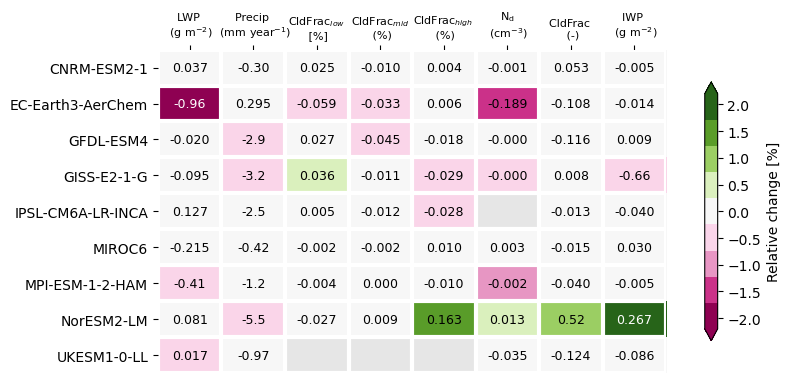

In [92]:
fig ,ax = plt.subplots(figsize=(8.3, 4.2))

ax.grid(color='w', linestyle='-', linewidth=3, which='minor')
ax.set_xticks(np.arange(vis_df.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(vis_df.shape[0]+1)-.5, minor=True)

ax.spines[:].set_visible(False)

cmap = mpl.colormaps.get_cmap('PiYG').resampled(9)
cmap.set_bad("#E6E6E6")
# cmap.set_gamma(0.9)
im=ax.imshow(vis_rel, cmap=cmap, aspect='auto', vmin=-2.2, vmax=2.2)
cbar = ax.figure.colorbar(im, ax=ax, location='right', pad=0.06, shrink=0.8, extend='both')
# cbar.ax.invert_yaxis()
cbar.ax.set_yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
# cbar.ax.set_yticklabels(['1','2','3','4','5','6','7','8','9'])
cbar.ax.set_ylabel('Relative change [%]')
# plt.savefig(snakemake.output.outpath, bbox_inches='tight')
ax.set_xticks(np.arange(vis_df.shape[1]), labels=vis_df.columns, fontsize=8)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(vis_df.shape[0]), labels=vis_df.index, fontsize=10)
ax.tick_params(which="minor", bottom=False, left=False, top=False)

texts = annotate_heatmap(im, data=vis_df.values, threshold=2, fontsize=9)

plt.savefig(snakemake.output.outpath, bbox_inches='tight')
